In [3]:
import os

all_paths = []
for root, dirs, files in os.walk("./processed_data"):
    for file in files:
        if file.endswith(".txt"):
             all_paths.append(os.path.join(root, file))



In [2]:
# load tokenizer
from transformers import AutoTokenizer

context_length = 512
tokenizer = AutoTokenizer.from_pretrained("./new_tokenizer")

In [2]:
tokenizer('Hvað er að frétta 😁 ?')

{'input_ids': [5645, 299, 276, 8633, 221, 173, 254, 247, 224, 10067], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [6]:

from datasets import load_dataset

portion = 1
all_paths = all_paths[:int(len(all_paths) * portion)]

train_paths = all_paths[:int(len(all_paths) * 0.8)]
test_paths = all_paths[int(len(all_paths) * 0.8):]

dataset = load_dataset('text', data_files={"train": train_paths, "test":test_paths}).with_format("torch")

train_dataset = dataset['train']
test_dataset = dataset['test']


Resolving data files:   0%|          | 0/636442 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/159111 [00:00<?, ?it/s]

In [7]:
from itertools import chain


context_length = 512

def tokenize_function(examples):
    # sequence length is the same as the context length
    examples = tokenizer(examples["text"])
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    if total_length >= context_length:
        total_length = (total_length // context_length) * context_length

    result = {
        k: [t[i : i + context_length] for i in range(0, total_length, context_length)]
        for k, t in concatenated_examples.items()
    }

    return result


tokanized_train_dataset = train_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=["text"])
tokanized_test_dataset = test_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=["text"])

In [8]:
# save the tokenized datasets
tokanized_train_dataset.save_to_disk("tokanized_train_dataset")
tokanized_test_dataset.save_to_disk("tokanized_test_dataset")

Saving the dataset (0/2 shards):   0%|          | 0/373884 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/93512 [00:00<?, ? examples/s]

In [1]:
from datasets import load_from_disk

# load from disk
tokanized_train_dataset = load_from_disk("tokanized_train_dataset")
tokanized_test_dataset = load_from_disk("tokanized_test_dataset")

# shuffle the datasets
tokanized_train_dataset = tokanized_train_dataset.shuffle()
tokanized_test_dataset = tokanized_test_dataset.shuffle()

In [4]:
tokanized_train_dataset, tokanized_test_dataset

(Dataset({
     features: ['input_ids', 'attention_mask'],
     num_rows: 373884
 }),
 Dataset({
     features: ['input_ids', 'attention_mask'],
     num_rows: 93512
 }))

In [3]:
tokanized_train_dataset[100]["input_ids"].shape == tokanized_train_dataset[100][
    "attention_mask"
].shape == (context_length,)

True

In [4]:
from transformers import GPT2Config, GPT2LMHeadModel

scale = 1

# Initializing a GPT2 configuration
configuration = GPT2Config(
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    n_embd=int(768 * scale),
    n_layer=int(12 * scale),
    n_head=int(12 * scale),
        
)

# Initializing a model from the configuration
model = GPT2LMHeadModel(configuration)

# Accessing the model configuration
configuration = model.config

In [5]:
model.config

GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "embd_pdrop": 0.1,
  "eos_token_id": 0,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 512,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.37.0.dev0",
  "use_cache": true,
  "vocab_size": 32000
}

In [8]:
model_size = sum(t.numel() for t in model.parameters())
print(f"ICE GPT-2 size: {model_size/1000**2:.1f}M parameters")

ICE GPT-2 size: 110.4M parameters


In [8]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False, pad_to_multiple_of=None)

In [10]:
import torch
torch.cuda.is_available()

True

In [6]:
!nvidia-smi

Tue Mar 12 18:07:58 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   37C    P8    15W / 250W |   1095MiB /  8192MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
from transformers import Trainer, TrainingArguments
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)

batch_size = 4

args = TrainingArguments(
    output_dir="icebreaker",
    overwrite_output_dir=True,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="steps",
    # eval_steps=5_000,
    eval_steps=10,
    logging_steps=20,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    # warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=100,
    save_total_limit=2,
    fp16=True,
)

# import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokanized_train_dataset,
    eval_dataset=tokanized_test_dataset,
    data_collator=data_collator,
    optimizers=(optimizer, None),)

trainer.train(resume_from_checkpoint=True)

There were missing keys in the checkpoint model loaded: ['lm_head.weight'].
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sigurdurhaukur (sigurdurhaukur-team). Use `wandb login --relogin` to force relogin


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
810,5.568800,5.495662
820,5.538700,5.482532
830,5.538700,5.470903
840,5.518000,5.466811
850,5.518000,5.439738
860,5.486500,5.425218
870,5.486500,5.415768
880,5.445100,5.391989
890,5.445100,5.383941
900,5.418500,5.382714


KeyboardInterrupt: 

In [ ]:
model.save_pretrained("icebreaker")
tokenizer.save_pretrained("icebreaker")

('icebreaker/tokenizer_config.json',
 'icebreaker/special_tokens_map.json',
 'icebreaker/vocab.json',
 'icebreaker/merges.txt',
 'icebreaker/added_tokens.json',
 'icebreaker/tokenizer.json')

In [2]:
import wandb

wandb.finish()

In [ ]:
from transformers import TextGenerationPipeline

# Load the trained model
model_path = "icebreaker"
model = GPT2LMHeadModel.from_pretrained(model_path)
model.eval()

# Create a text generation pipeline
pipeline = TextGenerationPipeline(model=model, tokenizer=tokenizer)

# Generate text
generated_text = pipeline("<Fréttir> Í gærkvöldi", max_length=1000, num_return_sequences=1, do_sample=True, top_k=50, top_p=0.8, temperature=1.0)

# Print the generated text
print(generated_text[0]['generated_text'])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


<Fréttir> Í gærkvöldiaráð, afhenti forseta Alþingis, Ástu Ragnheiði Jóhannesdóttur, frumvarp að nýrri stjórnarskrá í Iðnó í dag. Frumvarpið var samþykkt einróma með atkvæðum allra ráðsfulltrúa á síðasta fundi ráðsins, miðvikudaginn 27. júlí síðastliðinn. Í frumvarpinu er gert ráð fyrir að breytingar á stjórnarskrá séu framvegis bornar undir atkvæði allra kosningabærra manna í landinu til samþykktar eða synjunar. Fulltrúar í Stjórnlagaráði eru einhuga um að veita beri landsmönnum færi á að greiða atkvæði um nýja stjórnarskrá áður en Alþingi afgreiðir frumvarpið endanlega. Komi fram hugmyndir um breytingar á frumvarpi Stjórnlagaráðs lýsa fulltrúar í ráðinu sig reiðubúna til að koma aftur að málinu áður en þjóðaratkvæðagreiðsla fer fram. Frumvarpið hefst á aðfaraorðum og telur alls 114 ákvæði í níu köflum. Aðfaraorð frumvarpsins hefjast á eftirfarandi orðum: „Við sem byggjum Ísland viljum skapa réttlátt samfélag þar sem allir sitja við sama borð. Ólíkur uppruni okkar auðgar heildina og sa

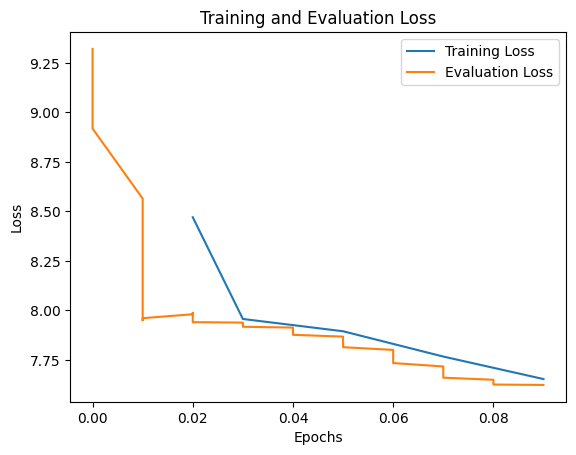

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

df = pd.DataFrame(trainer.state.log_history)
df.to_csv("./icebreaker/log_history.csv")

training_loss_data = []
eval_loss_data = []
for i in range(len(df)):
    row = df.iloc[i]
    epoch, train_loss, eval_loss = row["epoch"], row["loss"], row["eval_loss"]

    if not np.isnan(eval_loss):
        eval_loss_data.append((epoch, eval_loss))

    if not np.isnan(train_loss):
        training_loss_data.append((epoch, train_loss))

# Extract x and y values for training and evaluation losses
training_epochs, training_losses = zip(*training_loss_data)
eval_epochs, eval_losses = zip(*eval_loss_data)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the training loss
ax.plot(training_epochs, training_losses, label='Training Loss')

# Plot the evaluation loss
ax.plot(eval_epochs, eval_losses, label='Evaluation Loss')

# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and Evaluation Loss')

# Add a legend
ax.legend()

# Display the plot
plt.show()